In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
from glob import glob
import numpy as np
from collections import defaultdict

### Load the data and define some helpers

In [42]:
vfields = []
for f in glob('../data/vfields/seed-*.pkl'):
    with open(f, 'rb') as fp:
        vfields.append(pickle.load(fp))

len(vfields)

954

In [53]:
vfields_by_level = defaultdict(list)
for vf in vfields:
    vfields_by_level[vf['seed']].append(vf)

In [52]:
def get_vfields(seed: int, coef: float):
    for vf in vfields_by_level[seed]:
        if vf['coeff'] == coef:
            return vf

### Interactive vfield plot explorer

In [45]:
from ipywidgets import interact, IntSlider, FloatSlider

seed_max = max(vf['seed'] for vf in vfields)
min_coeff, max_coeff = min(vf['coeff'] for vf in vfields), max(vf['coeff'] for vf in vfields)

def _coeffs_for(seed: int):
    return sorted(set(vf['coeff'] for vf in vfields_by_level[seed]))

@interact(seed = IntSlider(min=0, max=99, step=1, value=0), coeff = FloatSlider(min=min_coeff, max=max_coeff, step=0.1, value=1.0))
def interact_vfields(seed: int, coeff: float):
    # set coeff to nearest available in vfields_by_level[seed]
    coeff = min(_coeffs_for(seed), key=lambda x: abs(x - coeff))
    vfs = get_vfields(seed, coeff)

    fig, ax = plt.subplots(1,2, figsize=(10, 5))
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])

    for i, vf in enumerate((vfs['original_vfield'], vfs['patched_vfield'])):
        legal_mouse_positions, arrows, grid = vf['legal_mouse_positions'], vf['arrows'], vf['grid']

        ax[i].set_xlabel("Original vfield" if i == 0 else "Patched vfield")
        ax[i].quiver(
            [x[1] for x in legal_mouse_positions], [x[0] for x in legal_mouse_positions],
            [x[1] for x in arrows], [x[0] for x in arrows], color='red',
        )
        ax[i].imshow(grid, origin='lower')

    plt.title(f"Seed {seed}, coeff {coeff}")
    plt.show()

interactive(children=(IntSlider(value=0, description='seed', max=99), FloatSlider(value=1.0, description='coef…

### Get dot products with cheese direction

In [46]:
from procgen_tools import maze

# TODO: Test & visualize this, could very easily be wrong
def cheese_direction_similarity(vf):
    (cx, cy) = maze.get_cheese_pos(vf['grid'])
    sims = []
    for (mx, my), (ax, ay) in zip(vf['legal_mouse_positions'], vf['arrows']):
        norm = ((cx - mx)**2 + (cy - my)**2)**0.5
        cheese_direction = (cx - mx / norm, cy - my / norm)
        norm = ((ax)**2 + (ay)**2)**0.5
        arrow_direction = (ax/norm, ay/norm)
        cosine_sim = np.dot(cheese_direction, arrow_direction)
        sims.append(cosine_sim)
    return sims

In [62]:
sims_original = []
sims_patched = []

def _avg_sim(vf):
    return sum(cheese_direction_similarity(vf)) / len(vf['legal_mouse_positions'])

for vfs in filter(lambda vf: vf['coeff'] == -1.0, vfields):
    sims_original.append(_avg_sim(vfs['original_vfield']))
    sims_patched.append(_avg_sim(vfs['patched_vfield']))

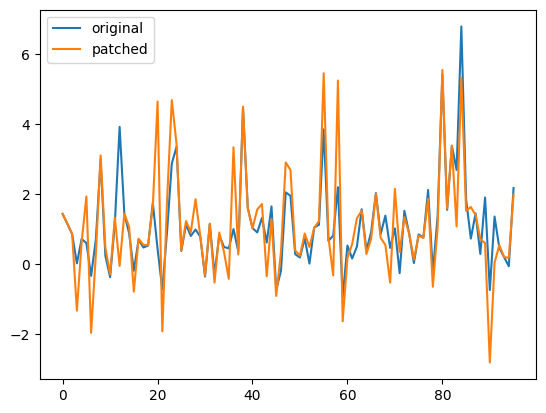

In [71]:
plt.plot(sims_original, label='original')
plt.plot(sims_patched, label='patched')
plt.legend()
plt.show()

In [78]:
np.array(sims_original).mean(), np.array(sims_patched).mean()

(1.0794774761787687, 1.0819670649628639)

In [74]:
import scipy.stats as stats
line = stats.linregress(sims_patched, sims_original)
line

LinregressResult(slope=0.6380849158755856, intercept=0.38909061255178545, rvalue=0.7870647673502531, pvalue=1.966533333588327e-21, stderr=0.051581977672350045, intercept_stderr=0.09787042864194893)

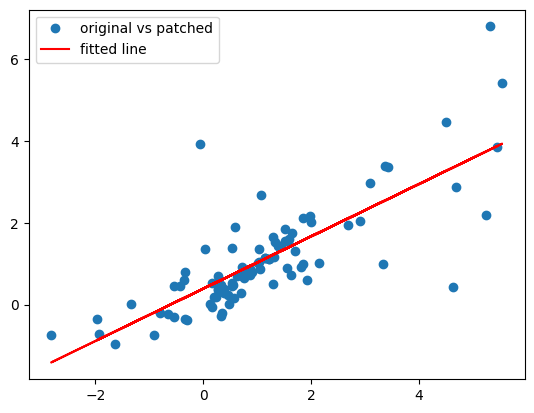

In [77]:
# plot regression line from scipy
plt.plot(sims_patched, sims_original, 'o', label='original vs patched')
plt.plot(sims_patched, line.intercept + line.slope*np.array(sims_patched), 'r', label='fitted line')
plt.legend()
plt.show()